In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.unequal_fee import UnequalFee
from copy import deepcopy

fee_algos_to_consider = {
    "fixed_fee": FixedFee(exchange_fee_rate=0.0015), # 15 bps
    "continuous_fee_perfect_oracle": UnequalFee(fee_rate_in_arbitrage_direction=0.002, fee_rate_in_non_arbitrage_direction=0.001), # 20/10 bps
}

experiment_configs = {}

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_name = f"{period_alias}_{fee_algo_alias}"
        experiment_configs[experiment_name] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [3]:
from pprint import pprint

pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0),
                               end_time=datetime.datetime(2022, 11, 16, 12, 0),
                               A_symbol='ETH',
                               B_symbol='BTC',
                               stable_coin_symbol='USDT',
                               candle_interval='5m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.0015),
           informed_user=<user.informed_user.InformedUser object at 0x117320080>,
           uninformed_users=UninformedUsersConfig(uninformed_user=<user.uninformed_user.UninformedUser object at 0x12ec568d0>,
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           total_tokens=100000)


In [4]:
pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0),
                               end_time=datetime.datetime(2022, 11, 16, 12, 0),
                               A_symbol='ETH',
                               B_symbol='BTC',
                               stable_coin_symbol='USDT',
                               candle_interval='5m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.0015),
           informed_user=<user.informed_user.InformedUser object at 0x117320080>,
           uninformed_users=UninformedUsersConfig(uninformed_user=<user.uninformed_user.UninformedUser object at 0x12ec568d0>,
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           total_tokens=100000)


In [5]:
from experiments.run_experiment import run_experiment
from experiments.experiment import ExperimentResult
import numpy as np

experiment_results: dict[str, ExperimentResult] = {}


for experiment_name, experiment_config in experiment_configs.items():
    np.random.seed(0)
    experiment_results[experiment_name] = run_experiment(experiment_config)

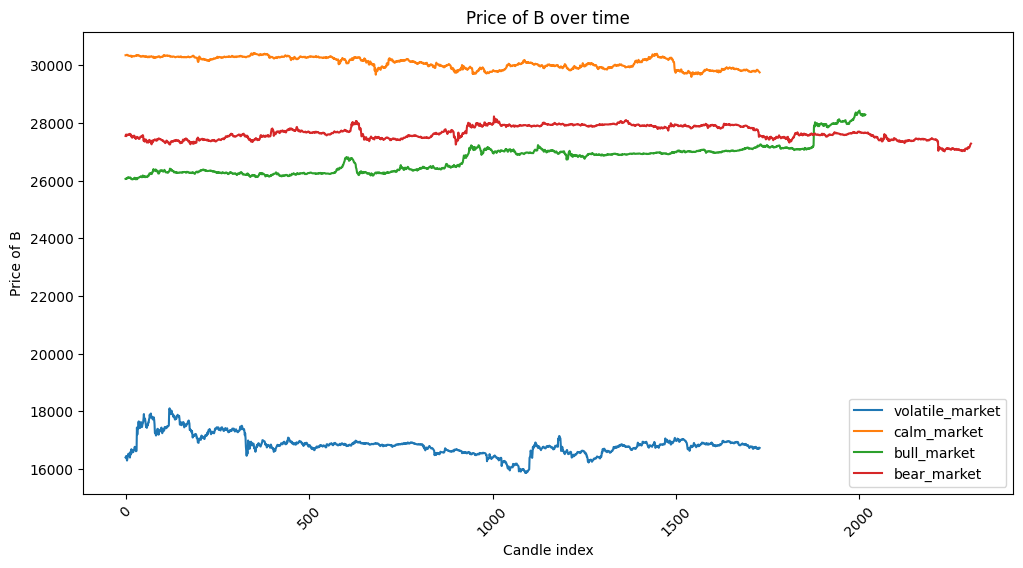

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_B"], label=period_alias)
    plt.title("Price of B over time")

plt.ylabel("Price of B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

### Results

In [7]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiment_summary

In [8]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    plot_participants_markouts(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )
    plot_impermanent_loss(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    summary = get_experiment_summary(
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    display(summary)

### Results for bull market

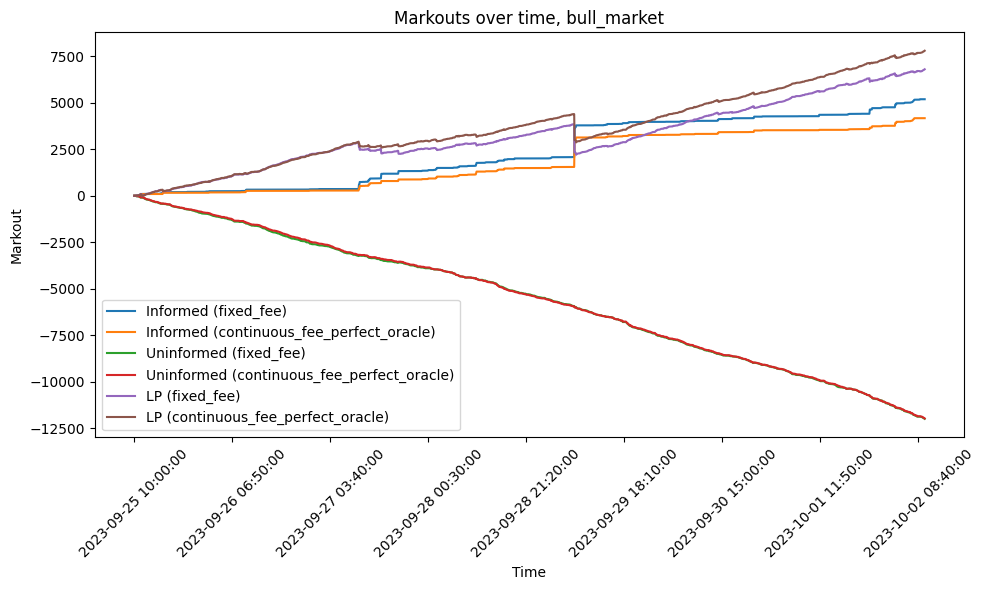

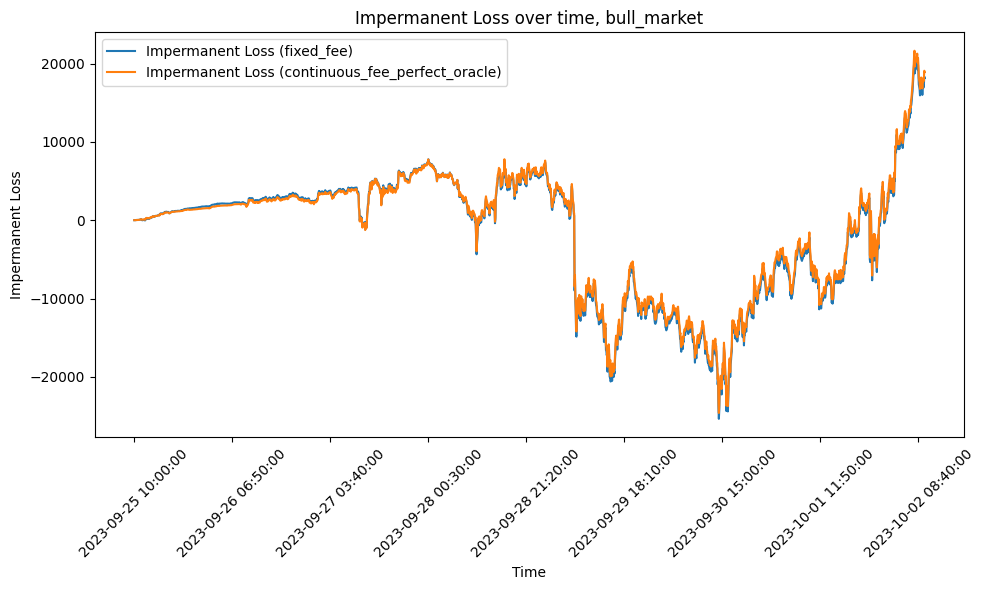

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,5194.288822,-12000.028867,6805.740045,18144.845246
1,continuous_fee_perfect_oracle,4174.950952,-11978.400150,7803.449199,18898.968966


In [9]:
plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

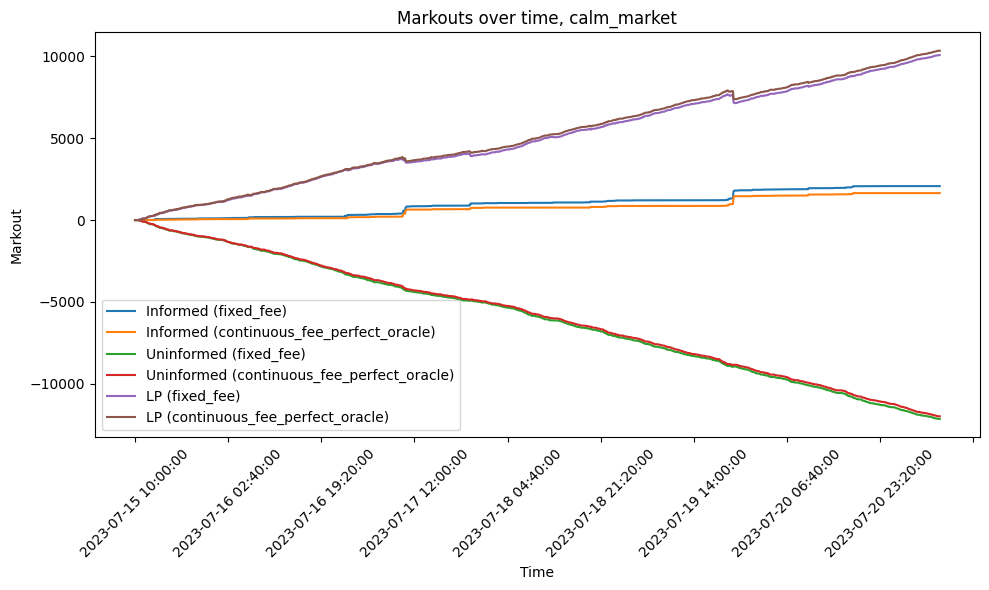

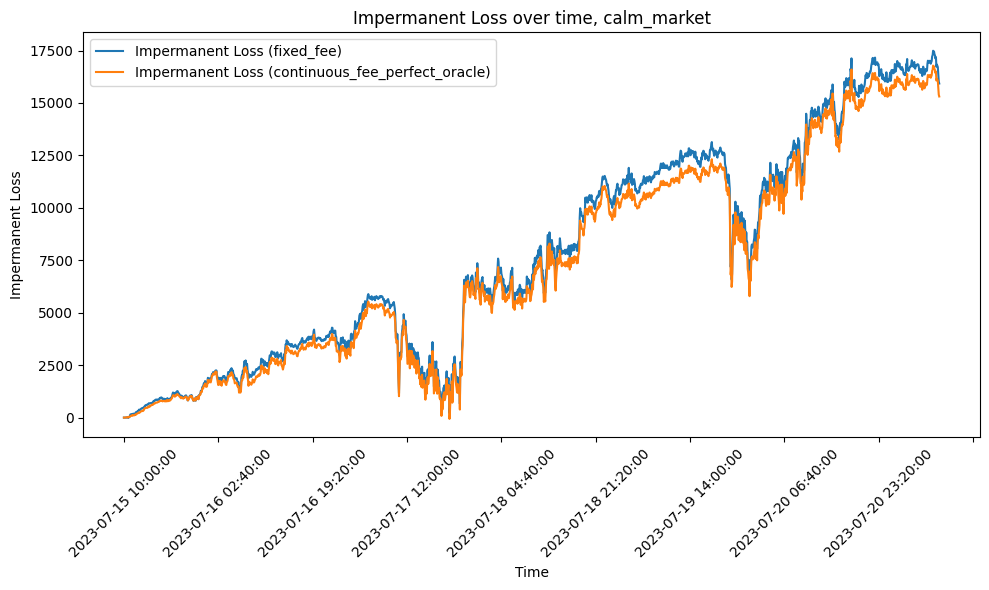

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,2075.096783,-12156.224088,10081.127304,15926.951192
1,continuous_fee_perfect_oracle,1647.371896,-11996.835089,10349.463193,15310.177009


In [10]:
plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

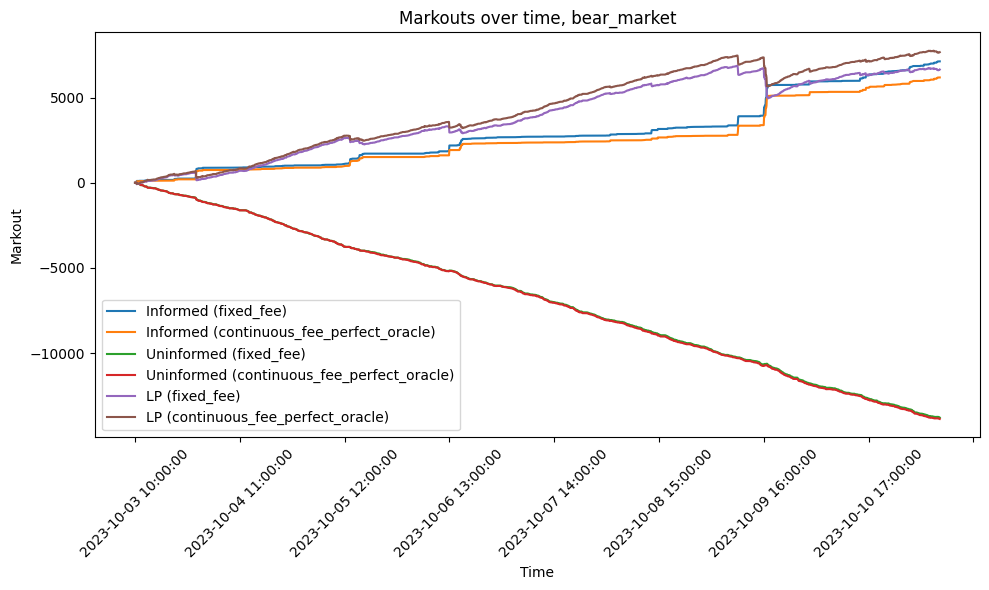

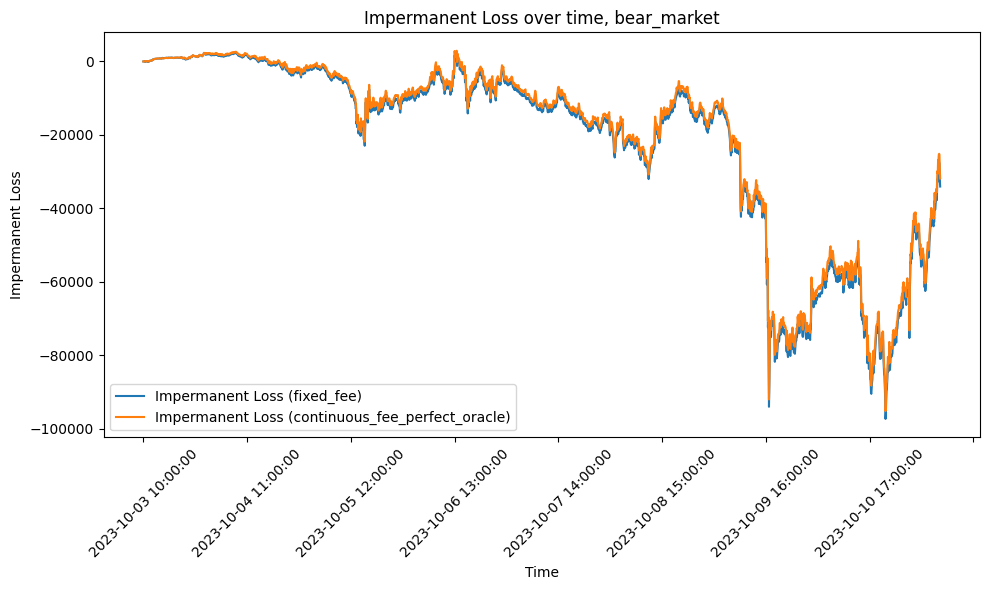

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,7139.877904,-13799.89144,6660.013536,-34033.600927
1,continuous_fee_perfect_oracle,6194.442196,-13873.73524,7679.293043,-31859.045997


In [11]:
plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

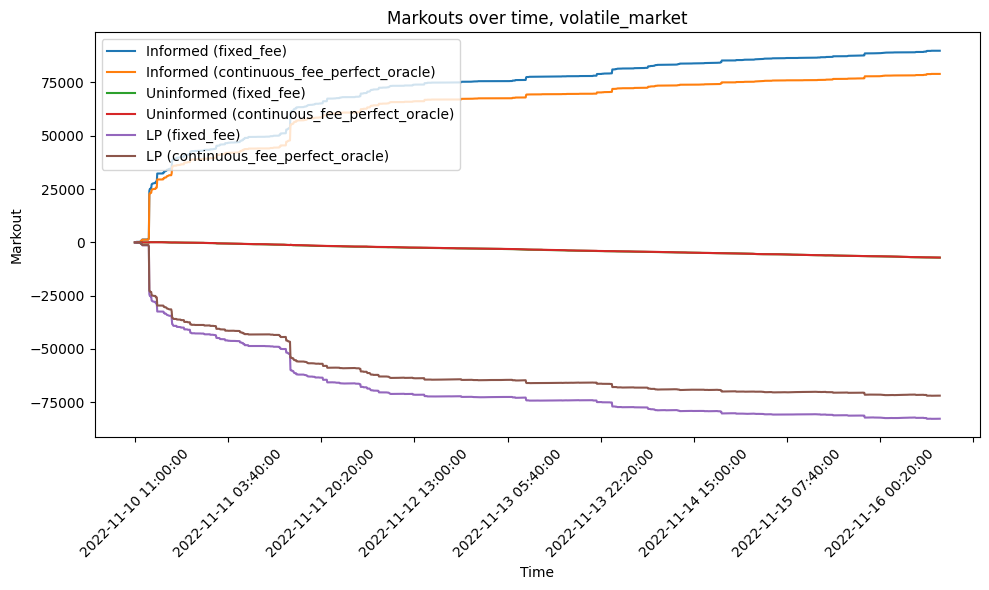

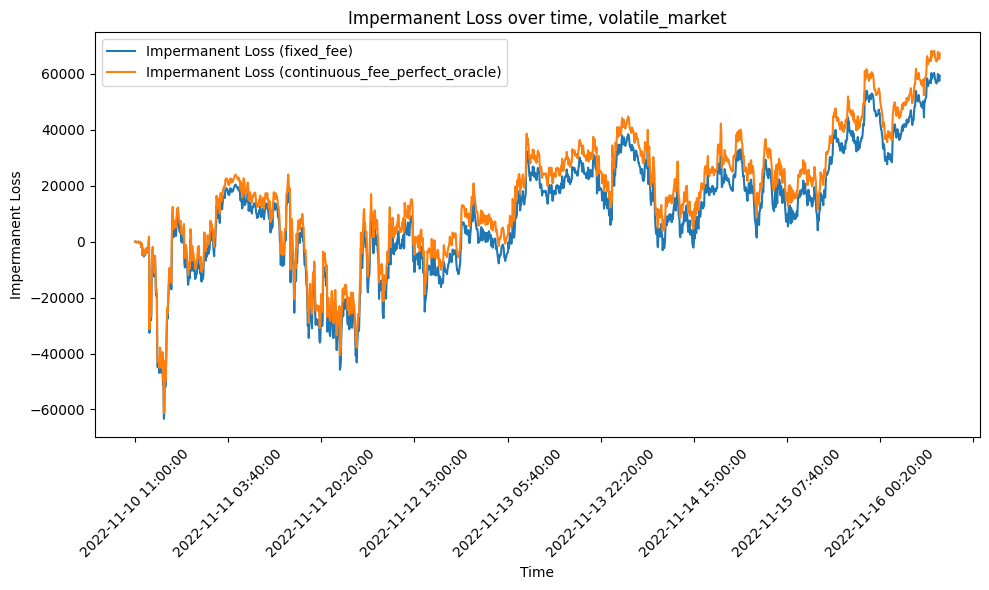

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,89861.584269,-7160.321189,-82701.263080,59331.120829
1,continuous_fee_perfect_oracle,78992.423286,-7117.163222,-71875.260064,67225.140563


In [12]:
plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))